In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [ ]:
import os
import spacy
import math
import array
import pandas as pd
from tqdm import tqdm
import re

#Main Functions

In [ ]:
def clean(s): #Function to clean the data
  clean_list = ['\n', '\n\n', '\n \n\n', '\n\n\n', "'", '“', '\n\n \n\n\n', '؟', '،', '!', ')', '(', '\n \n\n\n', ', ', '‘', '\n\n\n\n', '٪','۔','\n\n\n ','۔']
  s = [x for x in s if x not in clean_list]
  return s


In [ ]:
def stopWordList(): #function to load and send stop word list
  stop_word_list = []
  stopword_file = open('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/stopwords-ur.txt','r')
  stop_word_list = stopword_file.readlines()
  #removing \n form the words in the list
  stop_word_list =list(map(lambda s:s.strip(), stop_word_list ))
  return stop_word_list

In [ ]:
def StopWordRemoval(stopWordsList_,list1):
   list_= [x for x in list1 if x not in stopWordsList_]
   return list_

In [ ]:
def FilesCounter(path,category): #Function that will return total number of files in a directory

  TotalFiles= 0

  for base, dirs, files in os.walk(path):
      for Files in files:
          TotalFiles += 1
  print('Total number of files in ',category,': ',TotalFiles)
  return TotalFiles

In [ ]:
def removeDuplicates(path): #Function to remove the duplicates for boolean naive classifier
  listOfData=[]
  for subdir, dirs, files in os.walk(path):
      for filename in files:
          filepath=""
          data__=""
          list_data=[]
          filepath = subdir + os.sep + filename
          f = open(filepath)
          data__ = f.read()
          data_token_ = unlp(data__)
          list_data = tokensInList(data_token_) #tokenizing testing data
          list_data = set(clean(list_data)) #removing duplicates from each review
          listOfData = listOfData + list(list_data) #concatenating list of each review
          
  return listOfData

In [ ]:
def documentMaker(path): #Function to create single document of all files  
  data = ""
  countt=0
  for subdir, dirs, files in os.walk(path):
      for filename in files:
          filepath=""
          filepath = subdir + os.sep + filename
          file_ = open(filepath,'r')
          data = data+file_.read()
          data = data + " "
  return data

In [ ]:
def tokensInList(text): #function to convert spacy tokens to list type
  list__ = []
  for token in text:
      list__.append(token.text)
  return list__

In [ ]:
def frequency_dictionary(list__): #Function that returns a dictionary containing frequency of each words in the list
  frequency_distribution_dictionary = {}
  for item in list__:
    if (item in frequency_distribution_dictionary):
      frequency_distribution_dictionary[item] += 1
    else:
      frequency_distribution_dictionary[item] = 1
  return frequency_distribution_dictionary

In [ ]:
def likelihoodGenerator(dict__,size_in_class,vocabulary_length): #Function that returns the dictionry contating the likelihood probabilities
                                                                 #of all words in the dictionary
  for key, value in dict__.items():                              
        dict__[key]= (value + 1) /(size_in_class + vocabulary_length) #calculating likelihood probabilites including laplace smoothing
  return dict__

classification function

In [ ]:
def classifier(document_path,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,duplication,stop_words,stop_wordList):
  laplace_smooth_real = 1/(total_words_in_real + size_of_vocabulary) # to handle zero case for real
  laplace_smooth_fake = 1/(total_words_in_fake + size_of_vocabulary) # to handle zero case for fake
  
  f = open(document_path)
  data__ = f.read()
  data_token_ = unlp(data__)
  list_data = tokensInList(data_token_) #tokenizing testing data
  list_data = clean(list_data)#cleaning testing data
  
  if (duplication == 'y'): #if it is true, remove duplicates first, for boolean naive bayes
    list_data = set(list_data)
    
  if (stop_words == 'y'): #if it is true, remove stop words first
    #removing
    list_data =StopWordRemoval(stop_wordList, list_data)

  count=0
  for i in list_data:
    count=count+1
    if count == 1:
      prob_prod= math.log( likelihood_dictionary_real.get(i,laplace_smooth_real)) #taking log to avoid underflow problem
    else:
      prob_prod= prob_prod+ math.log( likelihood_dictionary_real.get(i,laplace_smooth_real))#taking log to avoid underflow problem
      #print(" else: ", prob_prod)

  count = 0
  for i in list_data:
    count = count+1
    if count == 1:
      prob_prod2= math.log(likelihood_dictionary_fake.get(i,laplace_smooth_fake))#taking log to avoid underflow problem
    else: 
      prob_prod2= prob_prod2 + math.log(likelihood_dictionary_fake.get(i,laplace_smooth_fake))#taking log to avoid underflow problem




  prob_prod =prob_prod + math.log(prior_prob_real)#taking log to avoid underflow problem
  prob_prod2 = prob_prod2 + math.log( prior_prob_fake)#taking log to avoid underflow problem

  
  if (prob_prod>prob_prod2):
    return 1 #real
  else:
    return 0 #fake

Prediction Function

In [ ]:
def predictedList(path,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,duplication,stop_words,stop_wordList): #function that returns the list of predicted labels
  list__=[]
  for subdir, dirs, files in os.walk(path):
      for filename in files:
          filepath=""
          filepath = subdir + os.sep + filename
          predicted_label=classifier(filepath,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,duplication,stop_words,stop_wordList )
          list__.append(predicted_label)
  return list__

Evaluation Matric Functions

In [ ]:
def ConfusionMatrix_Generator(actual_labels_list_testset,real_test_predicted_labels,fake_test_predicted_labels): #Function to generate confusion Matrix
  groundtruth_and_prediction_dictionary = {'Actual_Labels': actual_labels_list_testset,
                                      'Predicted_labels': real_test_predicted_labels+fake_test_predicted_labels }
  df = pd.DataFrame(groundtruth_and_prediction_dictionary, columns=['Actual_Labels','Predicted_labels'])
  confusion_matrix = pd.crosstab(df['Actual_Labels'], df['Predicted_labels'], rownames=['Actual'], colnames=['Predicted'])
  return confusion_matrix

In [ ]:
def All_in_one_matric_Generator(confusion_matrix): #Function that will take Confusion matrix as input and
                                                   #returns a dictionary that contains Accuracy,F1 Score, Precision
                                                   #Recall
  TN = confusion_matrix[0][0]
  TP = confusion_matrix[1][1]
  FN = confusion_matrix[0][1]
  FP = confusion_matrix[1][0]

  Accuracy = (TN+TP)/(TN+TP+FN+FP)
  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  F_one_score = (2*Precision*Recall)/(Precision+Recall)
  
  matric_dict = {'Accuracy': Accuracy,
                 'Precision': Precision,
                 'Recall': Recall,
                 'F1 Score': F_one_score}
  return matric_dict

# Loading And Pre-Processing the Training Data

Loading Training Set

In [ ]:
real_doc_string_train = documentMaker('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Real')
fake_doc_string_train = documentMaker('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Fake')

In [ ]:
print(real_doc_string_train)

پاکستان کے وزیراعظم عمران خان سعودی عرب کے دارالحکومت ریاض میں ملک میں سرمایہ کاری کے حوالے سے سالانہ کانفرنس میں شرکت کر رہے ہیں حکومت پاکستان کا کہنا ہے کہ سعودی عرب نے پاکستان کو معاشی بحران سے نمٹنے میں مدد کے لیے ایک سال کے لیے تین ارب ڈالر دینے پر اتفاق کیا ہے دفترِ خارجہ کی جانب سے منگل کی شب جاری ہونے والے اعلامیے میں بتایا گیا ہے کہ یہ فیصلہ وزیر اعظم عمران خان کی سعودی قیادت سے ملاقات کے بعد کیا گیا
عمران خان سعودی عرب میں سرمایہ کاری کے حوالے سے سالانہ کانفرنس میں شرکت کے لیے ریاض میں موجود ہیں
اعلامیے کے مطابق سعودی عرب پاکستان کو نہ صرف ایک سال کے لیے تین ارب ڈالر دے گا بلکہ تین سال تک مؤخر ادائیگیوں پر تقریباً نو ارب ڈالر مالیت تک کا تیل دینے پر بھی رضامند ہو گیا ہے دفترِ خارجہ کا کہنا ہے کہ سعودی عرب کی جانب سے دیے جانے والے تین ارب ڈالر ادائیگیوں میں توازن لانے میں مدد دیں گے وزیراعظم ہاؤس کا کہنا ہے کہ سعودی عرب نے پاکستان میں آئل ریفائنری پراجیکٹ میں بھی دلچسپی کی تصدیق کی ہے اس کے علاوہ اعلامیہ میں بتایا گیا کہ سعودی حکومت بلوچستان میں معدنیات کی کانوں میں بھی دلچسپی

In [ ]:
print(fake_doc_string_train)




 عمران خان نے وزارتِ عظمیٰ کا عہدہ سنبھالنے کے بعد سعودی عرب قرضے مانگنے سعودی عرب کے دارالحکومت ریاض روانہ ہو گئے اس سرکاری دورے میں سعودی عرب کی حکومت سے پاکستان کو معاشی بحران سے نکالنے کی درخواست کریں گے اس بحران سے نمٹنے کے لیے حکومت پاکستان ایک سال کے لیے 20 ارب ڈالر مالی اداد دینے کی درخواست کرے گی جس کی سر برایہ خود وزیر اعظم پاکستان عمران خان کر رہے ہیں دفترِ خارجہ کی جانب سے منگل کی شب جاری ہونے والے اعلامیے میں بتایا گیا ہے کہ سعودی حکام نے فیصلہ کیا ہے کہ وہ وزیر اعظم عمران خان کی درخواست پر 10 ارب ڈالر بطور مالہ امداد دینے پر اتفاق کیا ہے 
عمران خان سعودی عرب میں سرمایہ کاری کے حوالے سے کشکول لیے مالی معاونت کی غرض سے ریاض میں موجود ہیں عمران خان کو خود تو اپنی عزت کا احساس نہیں مگر انھیں غیور پاکستانی قوم کی غیرت کا بھی زرا خیال نہ آیا اور سوچے سمجھے بغیر وہ سعودی عرب روانہ ہو گئے جس پر سعودی حکام کو ترس آگیا اور انھوں نے پاکستان کو نہ صرف ایک سال کے لیے 10 ارب ڈالر دینے کا اعلان کیا بلکہ 5 سال تک مؤخر ادائیگیوں پر تقریباً 15 ارب ڈالر مالیت تک کا تیل دینے پر بھی رضامند

Pre-Processing

In [ ]:
#Tokenization
unlp = spacy.blank('ur')
realtext = unlp(real_doc_string_train)
faketext = unlp(fake_doc_string_train)

real_list_train= tokensInList(realtext)
fake_list_train= tokensInList(faketext)

In [ ]:
#Data Cleaning
real_list_train = clean(real_list_train) #cleaing
fake_list_train = clean(fake_list_train) #cleaing

In [ ]:
print(real_list_train)

['پاکستان', 'کے', 'وزیراعظم', 'عمران', 'خان', 'سعودی', 'عرب', 'کے', 'دارالحکومت', 'ریاض', 'میں', 'ملک', 'میں', 'سرمایہ', 'کاری', 'کے', 'حوالے', 'سے', 'سالانہ', 'کانفرنس', 'میں', 'شرکت', 'کر', 'رہے', 'ہیں', 'حکومت', 'پاکستان', 'کا', 'کہنا', 'ہے', 'کہ', 'سعودی', 'عرب', 'نے', 'پاکستان', 'کو', 'معاشی', 'بحران', 'سے', 'نمٹنے', 'میں', 'مدد', 'کے', 'لیے', 'ایک', 'سال', 'کے', 'لیے', 'تین', 'ارب', 'ڈالر', 'دینے', 'پر', 'اتفاق', 'کیا', 'ہے', 'دفترِ', 'خارجہ', 'کی', 'جانب', 'سے', 'منگل', 'کی', 'شب', 'جاری', 'ہونے', 'والے', 'اعلامیے', 'میں', 'بتایا', 'گیا', 'ہے', 'کہ', 'یہ', 'فیصلہ', 'وزیر', 'اعظم', 'عمران', 'خان', 'کی', 'سعودی', 'قیادت', 'سے', 'ملاقات', 'کے', 'بعد', 'کیا', 'گیا', 'عمران', 'خان', 'سعودی', 'عرب', 'میں', 'سرمایہ', 'کاری', 'کے', 'حوالے', 'سے', 'سالانہ', 'کانفرنس', 'میں', 'شرکت', 'کے', 'لیے', 'ریاض', 'میں', 'موجود', 'ہیں', 'اعلامیے', 'کے', 'مطابق', 'سعودی', 'عرب', 'پاکستان', 'کو', 'نہ', 'صرف', 'ایک', 'سال', 'کے', 'لیے', 'تین', 'ارب', 'ڈالر', 'دے', 'گا', 'بلکہ', 'تین', 'سال', 'تک', 'مؤ

In [ ]:
print(fake_list_train)

['عمران', 'خان', 'نے', 'وزارتِ', 'عظمیٰ', 'کا', 'عہدہ', 'سنبھالنے', 'کے', 'بعد', 'سعودی', 'عرب', 'قرضے', 'مانگنے', 'سعودی', 'عرب', 'کے', 'دارالحکومت', 'ریاض', 'روانہ', 'ہو', 'گئے', 'اس', 'سرکاری', 'دورے', 'میں', 'سعودی', 'عرب', 'کی', 'حکومت', 'سے', 'پاکستان', 'کو', 'معاشی', 'بحران', 'سے', 'نکالنے', 'کی', 'درخواست', 'کریں', 'گے', 'اس', 'بحران', 'سے', 'نمٹنے', 'کے', 'لیے', 'حکومت', 'پاکستان', 'ایک', 'سال', 'کے', 'لیے', '20', 'ارب', 'ڈالر', 'مالی', 'اداد', 'دینے', 'کی', 'درخواست', 'کرے', 'گی', 'جس', 'کی', 'سر', 'برایہ', 'خود', 'وزیر', 'اعظم', 'پاکستان', 'عمران', 'خان', 'کر', 'رہے', 'ہیں', 'دفترِ', 'خارجہ', 'کی', 'جانب', 'سے', 'منگل', 'کی', 'شب', 'جاری', 'ہونے', 'والے', 'اعلامیے', 'میں', 'بتایا', 'گیا', 'ہے', 'کہ', 'سعودی', 'حکام', 'نے', 'فیصلہ', 'کیا', 'ہے', 'کہ', 'وہ', 'وزیر', 'اعظم', 'عمران', 'خان', 'کی', 'درخواست', 'پر', '10', 'ارب', 'ڈالر', 'بطور', 'مالہ', 'امداد', 'دینے', 'پر', 'اتفاق', 'کیا', 'ہے', 'عمران', 'خان', 'سعودی', 'عرب', 'میں', 'سرمایہ', 'کاری', 'کے', 'حوالے', 'سے', 'کشکول'

# Loading And Pre-Processing the Testing Data

Loading Testing Set

In [ ]:
real_doc_string_test = documentMaker('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real')
fake_doc_string_test = documentMaker('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake')

In [ ]:
print(real_doc_string_test)

چین کے صدر شی جن پنگ نے منگل کے روز چین کی منڈی کو آزاد بنانے کے عمل کے چالیس سال مکمل ہونے کے موقعے پر خطاب کرتے ہوئے اصلاحات پر عمل درآمد کے عزم کا اظہار کیا ۔تاہم انہوں نے ان خصوصی اقدامات کا ذکر نہیں کیا جن کا شدت سے انتظار کیا جا رہا تھا۔

صدر شی نے اپنی طویل تقریر میں سرکاری معیشت کی حمایت کے ساتھ ساتھ نجی شعبےکی نمو پر بھی بات کی۔ انہوں نے کہا کہ چین اپنی منڈیوں کو مزید آزاد کرنے کی کوششوں کو وسعت دینے کا عمل جاری رکھے گا، اور بنیادی اصلاحات کے نفاذ کو یقینی بنائے گا۔

بیجنگ میں قائم گریٹ ہال آف دی پیپل میں خطاب کرتے ہوئے انہوں نے کہا کہ ہم ثابت قدمی کے ساتھ سرکاری معیشت کی ترقی کو مستحکم رکھیں گے اور اس کے ساتھ پوری توانائی سے نجی شعبے کی معیشت کو بھی تقویت دیں گے۔

چالیس سال قبل چین کے لیڈر آنجہانی ڈینگ ژاؤ پنگ نے اصلاحات اور آزاد منڈی کی مہم چلائی تھی۔ اور اسی کی وجہ سے چین نے شاندار صنعتی ترقی کی اور اب یہ دنیا کی دوسری بڑی معیشت بن چکا ہے۔ اس موقعے پر خطاب کرتے ہوئے صدر شی نے کہا کہ نئے امکانات کے کھلنے سے ترقی ہوتی ہے جبکہ خود کو مقید رکھنے سے پسماندگی پیدا ہوتی ہے۔

صدر ش

In [ ]:
print(fake_doc_string_test)


سٹٹگارٹ (اُردو پوائنٹ اخبارتازہ ترین 03 دسمبر2018ء) جرمنی کی موٹر ساز کمپنی ڈیملر نے آئندہ سال سے چین میں امرکین ٹیرف کی وجہ سے الیکٹرک کاریں بند کرنے کا اعلان کیا ہے ڈیملر کے چین کے حوالے سے شعبے کے سربراہ ہوبرٹس ٹروسکا نے بتایا کہ کمپنی آئندہ سال 2019 کے آخر تک چین میں الیکٹرک کاروں کی پیداوار بند کر دے گی جن میں مرسڈیز بینز ای کیو سی ماڈل بھی شامل ہے انکا مزید کہنا تھا کہ چین میں امرکین ٹیرف کی وجہ سے الیکٹرک کاریں جیسا کہ مرسڈیز بینز مے بیچ ماڈل کی طلب میں کمی آرہی ہے اس لیے یہ فیصلہ کیا گیا ہے

 

کراچی ( آن لائن ) حکومت نے عوام کو باہرکریڈٹ یا ڈیبٹ کارڈ استعمال کرنے پر ٹیکس معاف کر دیا اگر آپ سعودیہ عرب عمرہ یا حج کے سلسلے میں جارہے ہیں یا کسی کام کے سلسلے میں کسی اور ملک جا رہے ہیں تو اپکو ساتھ کرنسی لے جانے کی کوئی ضرورت نہیں ہے کیونکہ بینک ڈیبٹ یا کریڈٹ کارڈ کے استعمال پر آپکو ٹیکس ادا نہیں کرنا ہو گا ایف بی آر کے مطابق بیرون ممالک کارڈ استعمال کرنے کی صورت میں کوئی فیصد ٹیکس نہیں عائد کیا جائے گا تاکہ عام عوام کو فائدہ اور سہلولیات فراہم کیجا سکیں

 

بیجنگ چینی حکومت نے

Pre-Processing

In [ ]:
#Tokenization
unlp = spacy.blank('ur')
realtext = unlp(real_doc_string_test)
faketext = unlp(fake_doc_string_test)

real_list_test= tokensInList(realtext)
fake_list_test= tokensInList(faketext)

In [ ]:
#Data Cleaning
real_list_test = clean(real_list_test) #cleaing
fake_list_test = clean(fake_list_test) #cleaing

In [ ]:
print(real_list_test)

['چین', 'کے', 'صدر', 'شی', 'جن', 'پنگ', 'نے', 'منگل', 'کے', 'روز', 'چین', 'کی', 'منڈی', 'کو', 'آزاد', 'بنانے', 'کے', 'عمل', 'کے', 'چالیس', 'سال', 'مکمل', 'ہونے', 'کے', 'موقعے', 'پر', 'خطاب', 'کرتے', 'ہوئے', 'اصلاحات', 'پر', 'عمل', 'درآمد', 'کے', 'عزم', 'کا', 'اظہار', 'کیا', 'تاہم', 'انہوں', 'نے', 'ان', 'خصوصی', 'اقدامات', 'کا', 'ذکر', 'نہیں', 'کیا', 'جن', 'کا', 'شدت', 'سے', 'انتظار', 'کیا', 'جا', 'رہا', 'تھا', 'صدر', 'شی', 'نے', 'اپنی', 'طویل', 'تقریر', 'میں', 'سرکاری', 'معیشت', 'کی', 'حمایت', 'کے', 'ساتھ', 'ساتھ', 'نجی', 'شعبےکی', 'نمو', 'پر', 'بھی', 'بات', 'کی', 'انہوں', 'نے', 'کہا', 'کہ', 'چین', 'اپنی', 'منڈیوں', 'کو', 'مزید', 'آزاد', 'کرنے', 'کی', 'کوششوں', 'کو', 'وسعت', 'دینے', 'کا', 'عمل', 'جاری', 'رکھے', 'گا', 'اور', 'بنیادی', 'اصلاحات', 'کے', 'نفاذ', 'کو', 'یقینی', 'بنائے', 'گا', 'بیجنگ', 'میں', 'قائم', 'گریٹ', 'ہال', 'آف', 'دی', 'پیپل', 'میں', 'خطاب', 'کرتے', 'ہوئے', 'انہوں', 'نے', 'کہا', 'کہ', 'ہم', 'ثابت', 'قدمی', 'کے', 'ساتھ', 'سرکاری', 'معیشت', 'کی', 'ترقی', 'کو', 'مستحکم'

In [ ]:
print(fake_list_test)

['سٹٹگارٹ', 'اُردو', 'پوائنٹ', 'اخبارتازہ', 'ترین', '03', 'دسمبر2018ء', 'جرمنی', 'کی', 'موٹر', 'ساز', 'کمپنی', 'ڈیملر', 'نے', 'آئندہ', 'سال', 'سے', 'چین', 'میں', 'امرکین', 'ٹیرف', 'کی', 'وجہ', 'سے', 'الیکٹرک', 'کاریں', 'بند', 'کرنے', 'کا', 'اعلان', 'کیا', 'ہے', 'ڈیملر', 'کے', 'چین', 'کے', 'حوالے', 'سے', 'شعبے', 'کے', 'سربراہ', 'ہوبرٹس', 'ٹروسکا', 'نے', 'بتایا', 'کہ', 'کمپنی', 'آئندہ', 'سال', '2019', 'کے', 'آخر', 'تک', 'چین', 'میں', 'الیکٹرک', 'کاروں', 'کی', 'پیداوار', 'بند', 'کر', 'دے', 'گی', 'جن', 'میں', 'مرسڈیز', 'بینز', 'ای', 'کیو', 'سی', 'ماڈل', 'بھی', 'شامل', 'ہے', 'انکا', 'مزید', 'کہنا', 'تھا', 'کہ', 'چین', 'میں', 'امرکین', 'ٹیرف', 'کی', 'وجہ', 'سے', 'الیکٹرک', 'کاریں', 'جیسا', 'کہ', 'مرسڈیز', 'بینز', 'مے', 'بیچ', 'ماڈل', 'کی', 'طلب', 'میں', 'کمی', 'آرہی', 'ہے', 'اس', 'لیے', 'یہ', 'فیصلہ', 'کیا', 'گیا', 'ہے', '\n\n \n\n', 'کراچی', 'آن', 'لائن', 'حکومت', 'نے', 'عوام', 'کو', 'باہرکریڈٹ', 'یا', 'ڈیبٹ', 'کارڈ', 'استعمال', 'کرنے', 'پر', 'ٹیکس', 'معاف', 'کر', 'دیا', 'اگر', 'آپ', 'سع

#Prior Probabilities of Training data

In [ ]:
number_of_real_files_train = FilesCounter('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Real','real_train')
number_of_fake_files_train = FilesCounter('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Fake','fake_train')

#Finding priors i-e P(real) and P(fake)
total_no_train = number_of_real_files_train + number_of_fake_files_train

prior_prob_real_train = number_of_real_files_train/total_no_train
prior_prob_fake_train = number_of_fake_files_train/total_no_train
print("Probability of class real in training set: ",prior_prob_real_train)
print("Probability of class fake in training set: ",prior_prob_fake_train)

Total number of files in  real_train :  350
Total number of files in  fake_train :  288
Probability of class real in training set:  0.54858934169279
Probability of class fake in training set:  0.45141065830721006


# Actual Label List of Test Set

In [ ]:
real_label_list=list(array.array('i',(1,)*FilesCounter('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real','test_real')))
fake_label_list = list(array.array('i',(0,)*FilesCounter('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake','test_fake')))
actual_labels_list_testset = real_label_list + fake_label_list
print("1 represents Real")
print("2 represents Fake")
print(actual_labels_list_testset)

Total number of files in  test_real :  150
Total number of files in  test_fake :  112
1 represents Real
2 represents Fake
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#Training and Testing Naive Bayes (With stopwords)

***Training Naive Bayes (With stopWords)***

Calculating Size of Vocabulary

In [ ]:
total_words_in_real = len(real_list_train)
total_words_in_fake = len(fake_list_train)
total_list = set(real_list_train + fake_list_train)# concatenating fake and passing to set function to make vocabulary of unique words
size_of_vocabulary = len(total_list)

Likelihood Probabilities 

In [ ]:
real_frequency_dictionary = frequency_dictionary(real_list_train)
fake_frequency_dictionary = frequency_dictionary(fake_list_train)
#generating Likelihood Probabilities
likelihood_dictionary_real = likelihoodGenerator(real_frequency_dictionary,total_words_in_real,size_of_vocabulary)
likelihood_dictionary_fake = likelihoodGenerator(fake_frequency_dictionary,total_words_in_fake,size_of_vocabulary)


In [ ]:
for key, value in likelihood_dictionary_real.items():
        print(key,value)

Streaming output truncated to the last 5000 lines.
مقروض 2.1280519812163944e-05
پریشانیوں 2.1280519812163944e-05
دلا 7.093506604054648e-05
بلاگ 2.8374026416218594e-05
1398 2.1280519812163944e-05
اطمینان 3.546753302027324e-05
ئے 4.256103962432789e-05
پھنسے 1.4187013208109297e-05
عشروں 2.1280519812163944e-05
سالی 1.4187013208109297e-05
جدیدکاری 1.4187013208109297e-05
فقدان 1.4187013208109297e-05
فصلوں 2.1280519812163944e-05
ضرورتیں 1.4187013208109297e-05
مجبوراً 1.4187013208109297e-05
جکڑے 1.4187013208109297e-05
1955 1.4187013208109297e-05
76 2.1280519812163944e-05
چکائے 1.4187013208109297e-05
ملکیت 1.4187013208109297e-05
بوگی 1.4187013208109297e-05
دستاویزات 2.1280519812163944e-05
350 2.8374026416218594e-05
ناظرین 1.4187013208109297e-05
پائریٹس 2.1280519812163944e-05
کیریبین 2.1280519812163944e-05
جونی 5.674805283243719e-05
ڈیپ 6.384155943649183e-05
جانی 3.546753302027324e-05
عروج 4.256103962432789e-05
مان 1.4187013208109297e-05
لازم 1.4187013208109297e-05
ملزوم 1.4187013208109297e-05
پ

In [ ]:
for key, value in likelihood_dictionary_fake.items():
        print(key,value)

Streaming output truncated to the last 5000 lines.
طوطا 1.987933245201626e-05
چشم 1.987933245201626e-05
بتائے 2.981899867802439e-05
اذیت 2.981899867802439e-05
آزمائش 1.987933245201626e-05
پرینکا 0.00016897432584213822
چوپڑا 0.00023855198942419512
نک 0.0001292156609381057
جونس 0.00010933632848608944
مت 1.987933245201626e-05
عقائد 4.9698331130040655e-05
ہےہے 1.987933245201626e-05
گلوکار 7.951732980806505e-05
محل 3.975866490403252e-05
خاندان 0.00017891399206814636
میگزین 3.975866490403252e-05
رسومات 2.981899867802439e-05
والد 0.00021867265697217888
کیون 2.981899867802439e-05
مسیحی 1.987933245201626e-05
صیغہ 1.987933245201626e-05
چھ 6.957766358205691e-05
قنل 1.987933245201626e-05
زبان 0.00016897432584213822
انسٹا 3.975866490403252e-05
مس 4.9698331130040655e-05
فلموں 0.0003876469828143171
امیتابھ 0.00014909499339012196
بچن 0.00017891399206814636
سلمان 7.951732980806505e-05
سٹارز 1.987933245201626e-05
باجی 1.987933245201626e-05
بنیں 2.981899867802439e-05
حسرت 1.987933245201626e-05
ایوارڈز 6.

***Testing Naive Bayes (With stopWords)***

Prediction

In [ ]:
#list containing the predicted labels (on test set's Real directory)
list___=[] #empty string, because we donot want to remove duplicates and stopwords
real_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'n','n',list___)

#list containing the predicted labels (on test set's Fake directory)
fake_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'n','n',list___)


Evaluation

In [ ]:
confusionMatrix = ConfusionMatrix_Generator(actual_labels_list_testset,real_test_predicted_labels,fake_test_predicted_labels)

In [ ]:
confusionMatrix

Predicted   0    1
Actual            
0          87   25
1          47  103

Finding Accuracy, F1 score, Precision and Recall

In [ ]:
matric_dict_naive_withStopwords = All_in_one_matric_Generator(confusionMatrix)
print(matric_dict_naive_withStopwords)

{'Accuracy': 0.7251908396946565, 'Precision': 0.8046875, 'Recall': 0.6866666666666666, 'F1 Score': 0.7410071942446043}


#Training and Testing Naive Bayes (Without stopwords)

***Training Naive Bayes (Without stopWords)***

Removing Stopwords

In [ ]:
#loading stopwords
stopWordsList_ = stopWordList()
#removing stopwords from the training set list
new_real_list_train=StopWordRemoval(stopWordsList_,real_list_train)
new_fake_list_train=StopWordRemoval(stopWordsList_,fake_list_train)

calculating size of vocabulary

In [ ]:
total_words_in_real = len(new_real_list_train)
total_words_in_fake = len(new_fake_list_train)
total_list = set(new_real_list_train + new_fake_list_train)# concatenating fake and passing to set function to make vocabulary of unique words
size_of_vocabulary = len(total_list)

Likelihood Probabilities

In [ ]:
real_frequency_dictionary = frequency_dictionary(new_real_list_train)
fake_frequency_dictionary = frequency_dictionary(new_fake_list_train)
#generating Likelihood Probabilities
likelihood_dictionary_real = likelihoodGenerator(real_frequency_dictionary,total_words_in_real,size_of_vocabulary)
likelihood_dictionary_fake = likelihoodGenerator(fake_frequency_dictionary,total_words_in_fake,size_of_vocabulary)


***Testing Naive Bayes (Without stopWords)***

loading stopword list

In [ ]:
#loading stopwords
stopWordsList_ = stopWordList()
#removing stopwords from the training set list
#new_real_list_test=StopWordRemoval(stopWordsList_,real_list_test)
#new_fake_list_test=StopWordRemoval(stopWordsList_,fake_list_test)

prediction

In [ ]:
#list containing the predicted labels (on test set's Real directory)
list___=[] #empty string, because we donot want to remove duplicates and stopwords
real_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'n','y',stopWordsList_)

#list containing the predicted labels (on test set's Fake directory)
fake_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'n','y',stopWordsList_)

Evaluation

In [ ]:
confusionMatrix = ConfusionMatrix_Generator(actual_labels_list_testset,real_test_predicted_labels,fake_test_predicted_labels)

In [ ]:
confusionMatrix

Predicted   0    1
Actual            
0          88   24
1          49  101

Finding Accuracy, F1 score, Precision and Recall

In [ ]:
matric_dict_naive_withoutStopwords = All_in_one_matric_Generator(confusionMatrix)
print(matric_dict_naive_withStopwords)

{'Accuracy': 0.7251908396946565, 'Precision': 0.8046875, 'Recall': 0.6866666666666666, 'F1 Score': 0.7410071942446043}


#Training and Testing Boolean Naive Bayes (Without Duplicates)

***Training Boolean Naive Bayes***

Removing duplicates

In [ ]:
new_real_list_train=removeDuplicates('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Real')
new_fake_list_train=removeDuplicates('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Train/Fake')

Calculating size of vocabulary

In [ ]:
total_words_in_real = len(new_real_list_train)
total_words_in_fake = len(new_fake_list_train)
total_list = set(new_real_list_train + new_fake_list_train)# concatenating fake and passing to set function to make vocabulary of unique words
size_of_vocabulary = len(total_list)

likelihood probablities

In [ ]:
real_frequency_dictionary = frequency_dictionary(new_real_list_train)
fake_frequency_dictionary = frequency_dictionary(new_fake_list_train)
#generating Likelihood Probabilities
likelihood_dictionary_real = likelihoodGenerator(real_frequency_dictionary,total_words_in_real,size_of_vocabulary)
likelihood_dictionary_fake = likelihoodGenerator(fake_frequency_dictionary,total_words_in_fake,size_of_vocabulary)

***Testing Boolean Naive Bayes (Without Duplicates)***

Prediction

In [ ]:
#list containing the predicted labels (on test set's Real directory)
list___=[] #empty string, because we donot want to remove duplicates and stopwords
real_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'y','n',list___)

#list containing the predicted labels (on test set's Fake directory)
fake_test_predicted_labels = predictedList('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,'y','n',list___)

Evaluation

In [ ]:
confusionMatrix = ConfusionMatrix_Generator(actual_labels_list_testset,real_test_predicted_labels,fake_test_predicted_labels)

In [ ]:
confusionMatrix

Predicted   0    1
Actual            
0          86   26
1          43  107

Finding Accuracy, F1 score, Precision and Recall

In [ ]:
matric_dict_boolean_naive_bayes = All_in_one_matric_Generator(confusionMatrix)
print(matric_dict_naive_withStopwords)

{'Accuracy': 0.7251908396946565, 'Precision': 0.8046875, 'Recall': 0.6866666666666666, 'F1 Score': 0.7410071942446043}


#Comparison of Naive Bayes (with/without stopwords) and Boolean Naive Bayes

In [ ]:
matric_dict_naive_withStopwords

{'Accuracy': 0.7251908396946565,
 'F1 Score': 0.7410071942446043,
 'Precision': 0.8046875,
 'Recall': 0.6866666666666666}

In [ ]:
matric_dict_naive_withoutStopwords

{'Accuracy': 0.7213740458015268,
 'F1 Score': 0.7345454545454546,
 'Precision': 0.808,
 'Recall': 0.6733333333333333}

In [ ]:
matric_dict_boolean_naive_bayes

{'Accuracy': 0.7366412213740458,
 'F1 Score': 0.7561837455830389,
 'Precision': 0.8045112781954887,
 'Recall': 0.7133333333333334}

By seeing the results, we can say that the boolean naive bayes classifier out performs. Because its F1 score, precision, and Recall is closer to 1 and also we can see that, these measures are also greater with the measures of other models that are naive bayes with stopwords and naive bayes without stopwords.

# Visualizing the results

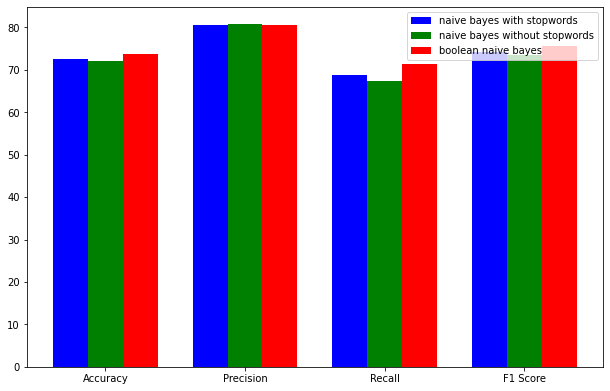

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = [[matric_dict_naive_withStopwords['Accuracy']*100, matric_dict_naive_withStopwords['Precision']*100, matric_dict_naive_withStopwords['Recall']*100,matric_dict_naive_withStopwords['F1 Score']*100],
[matric_dict_naive_withoutStopwords['Accuracy']*100, matric_dict_naive_withoutStopwords['Precision']*100, matric_dict_naive_withoutStopwords['Recall']*100,matric_dict_naive_withoutStopwords['F1 Score']*100],
[matric_dict_boolean_naive_bayes['Accuracy']*100, matric_dict_boolean_naive_bayes['Precision']*100, matric_dict_boolean_naive_bayes['Recall']*100,matric_dict_boolean_naive_bayes['F1 Score']*100]]
X = np.arange(4)
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(X + 0.00, data[0], color = 'b', width = 0.25,label ='naive bayes with stopwords')
plt.bar(X + 0.25, data[1], color = 'g', width = 0.25,label = 'naive bayes without stopwords')
plt.bar(X + 0.50, data[2], color = 'r', width = 0.25,label = 'boolean naive bayes')

plt.xticks([r + barWidth for r in range(len(data[0]))],
        ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.legend()
plt.show()


Also we can see in the bar plot, that boolean naive bayes out performs. Because its accuracy is highest, its precision is approximately equivalent to the precision of other models. The F1 score of boolean naive bayes is also highest.

# Extra credit work

what i am going to do is, i will concatenate the negation word and the word that is next to it. Like if a sentence is, "mujhay in ka pizza pasand nahi aya". so instead of calculating probability of "nahi" and "aya" alone, i will calculate the probability of "nahi aya" together.

In [ ]:
def negationConcat(list_,neg_words):
  ctr = 0
  new_word=""
  for word in list_:
    if (ctr+1<len(list_)):
      if list_[ctr+1] in neg_words: #if neg word found, concatinate it with the next word to it
        new_word=word+" "+list_[ctr+1]
        list_.pop(ctr)#remove word at index ctr
        list_.pop(ctr)#remove next word, i-e at index ctr now
        list_.insert(ctr,new_word)#inset the concatinated word
        new_word = ""
    ctr+=1
  return list_

In [ ]:
list_of_negation_words = ['نہیں','نہ','نا'] #we can icrease this list

concatenating the negation word with the next word to it

In [ ]:
n_real_list_train = negationConcat(real_list_train,list_of_negation_words)
n_fake_list_train = negationConcat(fake_list_train,list_of_negation_words)

Calculating size of vocabulary

In [ ]:
total_words_in_real = len(n_real_list_train)
total_words_in_fake = len(n_fake_list_train)
total_list = set(n_real_list_train + n_fake_list_train)# concatenating fake and passing to set function to make vocabulary of unique words
size_of_vocabulary = len(total_list)

***Training the model***

likelihood probabilities

In [ ]:
real_frequency_dictionary = frequency_dictionary(n_real_list_train)
fake_frequency_dictionary = frequency_dictionary(n_fake_list_train)
#generating Likelihood Probabilities
likelihood_dictionary_real = likelihoodGenerator(real_frequency_dictionary,total_words_in_real,size_of_vocabulary)
likelihood_dictionary_fake = likelihoodGenerator(fake_frequency_dictionary,total_words_in_fake,size_of_vocabulary)


***Testing the model***

classifier and prediction

some parameters of function and code needs changes to implement this extra work. so i have written new functions

In [ ]:
def classifier_extra(document_path,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,neg_words_):
  laplace_smooth_real = 1/(total_words_in_real + size_of_vocabulary) # to handle zero case for real
  laplace_smooth_fake = 1/(total_words_in_fake + size_of_vocabulary) # to handle zero case for fake
  
  f = open(document_path)
  data__ = f.read()
  data_token_ = unlp(data__)
  list_data = tokensInList(data_token_) #tokenizing testing data
  list_data = clean(list_data)#cleaning testing data
  list_data = negationConcat (list_data,neg_words_)

  count=0
  for i in list_data:
    count=count+1
    if count == 1:
      prob_prod= math.log( likelihood_dictionary_real.get(i,laplace_smooth_real)) #taking log to avoid underflow problem
    else:
      prob_prod= prob_prod+ math.log( likelihood_dictionary_real.get(i,laplace_smooth_real))#taking log to avoid underflow problem
      #print(" else: ", prob_prod)

  count = 0
  for i in list_data:
    count = count+1
    if count == 1:
      prob_prod2= math.log(likelihood_dictionary_fake.get(i,laplace_smooth_fake))#taking log to avoid underflow problem
    else: 
      prob_prod2= prob_prod2 + math.log(likelihood_dictionary_fake.get(i,laplace_smooth_fake))#taking log to avoid underflow problem




  prob_prod =prob_prod + math.log(prior_prob_real)#taking log to avoid underflow problem
  prob_prod2 = prob_prod2 + math.log( prior_prob_fake)#taking log to avoid underflow problem

  
  if (prob_prod>prob_prod2):
    return 1 #real
  else:
    return 0 #fake

In [ ]:
def predictedList_extra(path,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,list_of_negation_words): #function that returns the list of predicted labels
  list__=[]
  for subdir, dirs, files in os.walk(path):
      for filename in files:
          filepath=""
          filepath = subdir + os.sep + filename
          predicted_label=classifier_extra(filepath,likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,size_of_vocabulary,prior_prob_real,prior_prob_fake,list_of_negation_words )
          list__.append(predicted_label)
  return list__

Prediction

In [ ]:
#list containing the predicted labels (on test set's Real directory)
list___=[] #empty string, because we donot want to remove duplicates and stopwords
real_test_predicted_labels = predictedList_extra('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Real',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,list_of_negation_words)

#list containing the predicted labels (on test set's Fake directory)
fake_test_predicted_labels = predictedList_extra('/content/drive/MyDrive/NLP Online/Assignment#05/dataset/data.zip (Unzipped Files)/Test/Fake',
                                           likelihood_dictionary_real,total_words_in_real,likelihood_dictionary_fake,total_words_in_fake,
                                           size_of_vocabulary,prior_prob_real_train,prior_prob_fake_train,list_of_negation_words)

Evaluation

In [ ]:
confusionMatrix = ConfusionMatrix_Generator(actual_labels_list_testset,real_test_predicted_labels,fake_test_predicted_labels)

In [ ]:
confusionMatrix

Predicted   0    1
Actual            
0          86   26
1          47  103

In [ ]:
matric_dict_naive_ExtraCredit = All_in_one_matric_Generator(confusionMatrix)
print(matric_dict_naive_withStopwords)

{'Accuracy': 0.7251908396946565, 'Precision': 0.8046875, 'Recall': 0.6866666666666666, 'F1 Score': 0.7410071942446043}


Previous best was boolean naive bayes, so compairing this extra work with boolean naive bayes

In [ ]:
matric_dict_boolean_naive_bayes

{'Accuracy': 0.7366412213740458,
 'F1 Score': 0.7561837455830389,
 'Precision': 0.8045112781954887,
 'Recall': 0.7133333333333334}

so, more or less, both models(boolean naive and naive extra credit) are good. But the precision,F1 score and recall of boolean naive bayes is slighter higher